In [1]:
%pip install pygam

     |████████████████████████████████| 1.8 MB 1.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pygam.pygam import PoissonGAM,LinearGAM
import pandas as pd
from scipy.stats import lognorm
from scipy.signal import savgol_filter



In [3]:
df = pd.read_csv('../data/state_wise_daily.csv')
df = df[:630] #considering cases only till 10th oct 2020
df

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,08-Oct-20,2020-10-08,Recovered,78745,11,6102,283,2198,1006,154,...,1615,2092,35,5718,2067,389,3690,904,2970,0
626,08-Oct-20,2020-10-08,Deceased,967,1,42,1,9,2,4,...,29,15,1,68,12,3,45,14,63,0
627,09-Oct-20,2020-10-09,Confirmed,73305,24,5145,281,1019,1155,63,...,743,2180,33,5185,1891,223,3207,704,3573,0
628,09-Oct-20,2020-10-09,Recovered,82628,17,6110,198,2068,1424,161,...,1333,2148,71,5357,1878,408,4424,1239,3069,0


In [4]:
# we will be considering only the confirmed and deceased cases
df = df.drop(['Date_YMD'],axis=1)
df['Date'] = pd.to_datetime(df['Date'])
# df = df[df.Date>='2020-04-22']
df.columns

Index(['Date', 'Status', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN',
       'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD',
       'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN',
       'TG', 'TR', 'UP', 'UT', 'WB', 'UN'],
      dtype='object')

In [5]:
df.head()

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,2020-03-14,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,2020-03-14,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,2020-03-14,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-15,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,2020-03-15,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0


In [6]:
confirmed = df[df.Status=='Confirmed']
deceased = df[df.Status=='Deceased']
recovered = df[df.Status=='Recovered']

state = 'TT'
s_confirmed = np.array(confirmed[state])
s_deceased = np.array(deceased[state])
s_recovered = np.array(recovered[state])

In [7]:
confirmed

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,2020-03-14,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
3,2020-03-15,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
6,2020-03-16,Confirmed,15,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
9,2020-03-17,Confirmed,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
12,2020-03-18,Confirmed,37,0,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,2020-10-05,Confirmed,60130,15,4256,235,1518,907,133,2681,...,1029,2165,17,5395,1335,159,2971,510,3348,0
618,2020-10-06,Confirmed,71869,13,5795,224,1184,1265,129,2888,...,830,2121,25,5017,1983,275,3500,338,3370,0
621,2020-10-07,Confirmed,78809,23,5120,260,1307,1304,113,2846,...,852,2151,99,5447,2154,237,3389,630,3455,0
624,2020-10-08,Confirmed,70797,17,5292,212,1188,1244,102,2873,...,848,2138,12,5088,1896,214,3133,400,3526,0


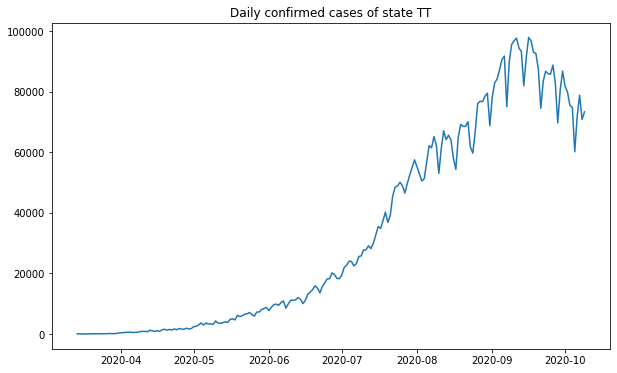

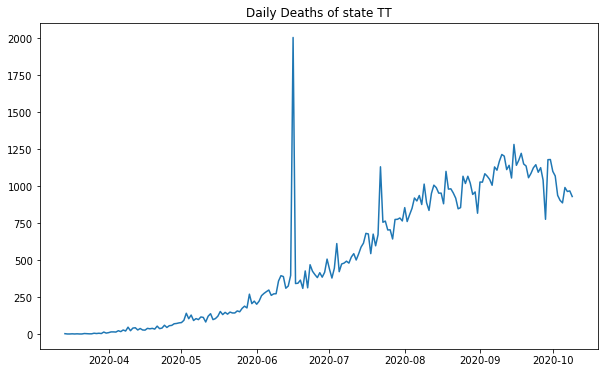

In [8]:
dates = confirmed['Date'].to_numpy()
plt.figure(figsize=(10,6))
plt.plot(dates,s_confirmed)
plt.title(f'Daily confirmed cases of state {state}')
plt.show()
plt.figure(figsize=(10,6))
plt.plot(dates,s_deceased)
plt.title(f'Daily Deaths of state {state}')
plt.show()

In [9]:
mu = 13
sigma = 12.7
CFR = 0.1/100
def nCFR(confirmed,deceased):
    ncfr = np.sum(deceased)/np.sum(confirmed)
    return ncfr*100

def PDF(x,mu,sigma):
    if(x==0):
        return 0
    pdf = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return pdf
    
def cCFR(confirmed,deceased):
    T = deceased.size
    e=[]
    den = 0
    for t in range(T):
        known_i = 0
        for s in range(0,t):
            known_i+=PDF(t-s,mu,sigma)*confirmed[s]
        den+=known_i
        e.append(known_i*CFR*10)
    ccfr = np.sum(deceased)/den
    return ccfr*10,e
    

In [10]:
print("Total confirmed cases: ",np.sum(s_confirmed))
print("Total deaths reported: ",np.sum(s_deceased))
ncfr = nCFR(s_confirmed,s_deceased)
ccfr,e = cCFR(s_confirmed,s_deceased)
print(f'nCFR of State {state} = ',ncfr)
print(f'cCFR of State {state} = ',ccfr)

Total confirmed cases:  6976461
Total deaths reported:  107459
nCFR of State TT =  1.5403081877760083
cCFR of State TT =  1.7852882313634801


In [11]:
print('Percentage reported (CFR of 0.1%) of state ',state,': ',min(np.sum(e)/np.sum(s_deceased),1)*100,'%')

Percentage reported (CFR of 0.1%) of state  TT :  5.601336425302423 %


In [12]:
y = s_deceased

model = PoissonGAM(n_splines=40)
T = s_deceased.size
X = []
t = np.arange(0,T)
for i in range(len(t)):
    X.append([i,s_confirmed[i]])

gam = model.fit(X,y)

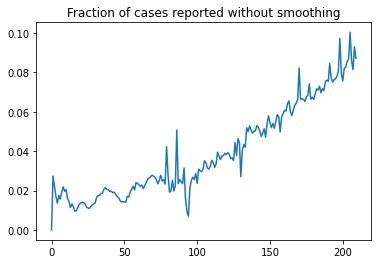

In [13]:
# gam.summary()
lam = model.predict(X)
f = e/(lam)
from scipy.signal import savgol_filter

plt.title('Fraction of cases reported without smoothing')
plt.plot(t,f)
plt.show()

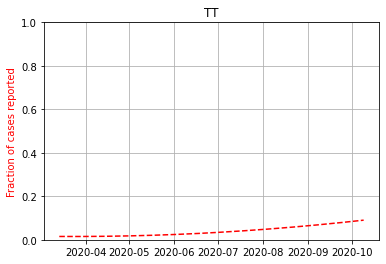

In [14]:
fhat = savgol_filter(f,201,2)
for i in range(len(t)):
    if(fhat[i]>1):
        fhat[i]=1

# plt.figure(figsize=(10,6))
plt.plot(dates,fhat,'r--')
plt.title(state)
plt.ylabel('Fraction of cases reported',color='r')
plt.grid()
plt.ylim((0,1))
plt.show()

In [15]:
def plot_plt(states, degree):
  state = states
  s_confirmed = np.array(confirmed[state])
  s_deceased = np.array(deceased[state])
  s_recovered = np.array(recovered[state])
  dates = confirmed['Date'].to_numpy()
  plt.figure(figsize=(10,6))
  plt.plot(dates,s_confirmed)
  plt.title(f'Daily confirmed cases of state {state}')
  plt.show()
  plt.figure(figsize=(10,6))
  plt.plot(dates,s_deceased)
  plt.title(f'Daily Deaths of state {state}')
  plt.show()
  mu = 13
  sigma = 12.7
  CFR = 0.1/100
  print("Total confirmed cases: ",np.sum(s_confirmed))
  print("Total deaths reported: ",np.sum(s_deceased))
  ncfr = nCFR(s_confirmed,s_deceased)
  ccfr,e = cCFR(s_confirmed,s_deceased)
  print(f'nCFR of State {state} = ',ncfr)
  print(f'cCFR of State {state} = ',ccfr)
  print('Percentage reported (CFR of 0.1%) of state ',state,': ',min(np.sum(e)/np.sum(s_deceased),1)*100,'%')
  y = s_deceased

  model = PoissonGAM(n_splines=40)
  T = s_deceased.size
  X = []
  t = np.arange(0,T)
  for i in range(len(t)):
      X.append([i,s_confirmed[i]])

  gam = model.fit(X,y)
  # gam.summary()
  lam = model.predict(X)
  f = e/(lam)

  plt.title('Fraction of cases reported without smoothing')
  plt.plot(t,f)
  plt.show()
  fhat = savgol_filter(f,201,degree)
  for i in range(len(t)):
      if(fhat[i]>1):
          fhat[i]=1

  f_1 = e/(lam+(1 * pow(lam/len(s_confirmed), 0.5)))
  fhat_1 = savgol_filter(f_1,201,2)

  for i in range(len(t)):
      if(fhat_1[i]>1):
          fhat_1[i]=1

  f_2 = e/(lam-(1*pow(lam/len(s_confirmed), 0.5)))
  fhat_2 = savgol_filter(f_2,201,2)

  for i in range(len(t)):
      if(fhat_2[i]>1):
          fhat_2[i]=1
  
  print('Fraction of cases reported with 95% confidence interval')

  plt.plot(dates,fhat,'r--')
  plt.fill_between(dates,fhat_1,fhat_2,alpha=0.1,color='r')
  plt.title(state)
  plt.ylabel('Fraction of cases reported',color='r')
  plt.grid()
  plt.ylim((0,1))
  plt.show()

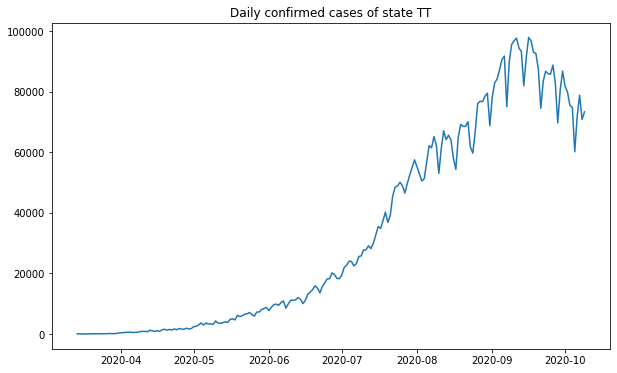

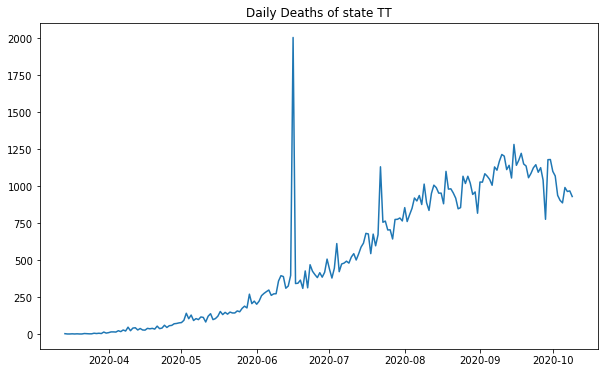

Total confirmed cases:  6976461
Total deaths reported:  107459
nCFR of State TT =  1.5403081877760083
cCFR of State TT =  1.7852882313634801
Percentage reported (CFR of 0.1%) of state  TT :  5.601336425302423 %


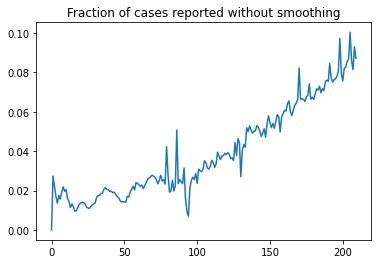

Fraction of cases reported with 95% confidence interval


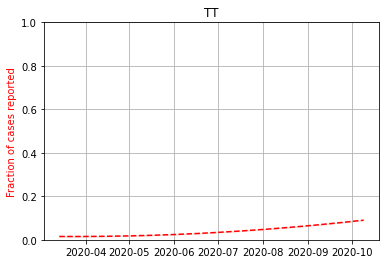

In [16]:
plot_plt('TT', 2)

In [17]:
df1 = pd.read_csv('../data/state_wise_daily.csv')
# df1 = df[:630] #considering cases only till 10th oct 2020
df1
# we will be considering only the confirmed and deceased cases
df1 = df1.drop(['Date_YMD'],axis=1)
df1['Date'] = pd.to_datetime(df1['Date'])
# df = df[df.Date>='2020-04-22']
df1.columns
confirmed = df1[df1.Status=='Confirmed']
deceased = df1[df1.Status=='Deceased']
recovered = df1[df1.Status=='Recovered']



In [20]:
def plot_plt1(states, degree):
  state = states
  s_confirmed = np.array(confirmed[state])
  s_deceased = np.array(deceased[state])
  s_recovered = np.array(recovered[state])
  dates = confirmed['Date'].to_numpy()
  plt.figure(figsize=(10,6))
  plt.plot(dates,s_confirmed)
  # print(dates)
  # plt.axvspan("2021-03", "2021-07", color='red', alpha=0.2)
  plt.axvspan(dates[370], dates[490],color='red',alpha = 0.2)
  plt.title(f'Daily confirmed cases of state {state}')
  plt.show()
  plt.figure(figsize=(10,6))
  plt.plot(dates,s_deceased)
  plt.title(f'Daily Deaths of state {state}')
  plt.show()
  mu = 13
  sigma = 12.7
  CFR = 0.1/100
  print("Total confirmed cases: ",np.sum(s_confirmed))
  print("Total deaths reported: ",np.sum(s_deceased))
  ncfr = nCFR(s_confirmed,s_deceased)
  ccfr,e = cCFR(s_confirmed,s_deceased)
  print(f'nCFR of State {state} = ',ncfr)
  print(f'cCFR of State {state} = ',ccfr)
  print('Percentage reported (CFR of 0.1%) of state ',state,': ',min(np.sum(e)/np.sum(s_deceased),1)*100,'%')
  y = s_deceased

  model = PoissonGAM(n_splines=40)
  T = s_deceased.size
  X = []
  t = np.arange(0,T)
  for i in range(len(t)):
      X.append([i,s_confirmed[i]])

  gam = model.fit(X,y)
  # gam.summary()
  lam = model.predict(X)
  f = e/(lam)

  plt.title('Fraction of cases reported without smoothing')
  plt.plot(t,f)
  plt.show()
  fhat = savgol_filter(f,201,degree)
  for i in range(len(t)):
      if(fhat[i]>1):
          fhat[i]=1

  f_1 = e/(lam+(1 * pow(lam/len(s_confirmed), 0.5)))
  fhat_1 = savgol_filter(f_1,201,2)

  for i in range(len(t)):
      if(fhat_1[i]>1):
          fhat_1[i]=1

  f_2 = e/(lam-(1*pow(lam/len(s_confirmed), 0.5)))
  fhat_2 = savgol_filter(f_2,201,2)

  for i in range(len(t)):
      if(fhat_2[i]>1):
          fhat_2[i]=1
  
  print('Fraction of cases reported with 95% confidence interval')
  plt.figure(figsize = (10,5))
  fig1, ax1  = plt.subplots(2, figsize = (10,6))
  ax1[0].plot(dates,s_confirmed,'r--')
  ax1[0].axvspan(dates[350], dates[490],color='red',alpha = 0.2)
  ax1[0].set_title("Daily Active cases in India")
  ax1[1].plot(dates, fhat,'r--')
  ax1[1].axvspan(dates[350], dates[490],color='red',alpha = 0.2)
  ax1[1].set_title('Fraction of cases reported in India')
  plt.tight_layout()
  plt.show()

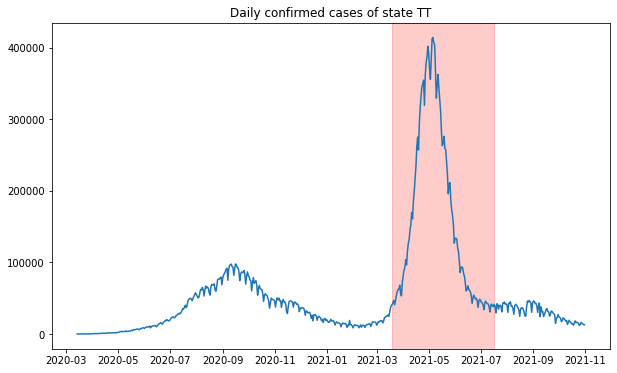

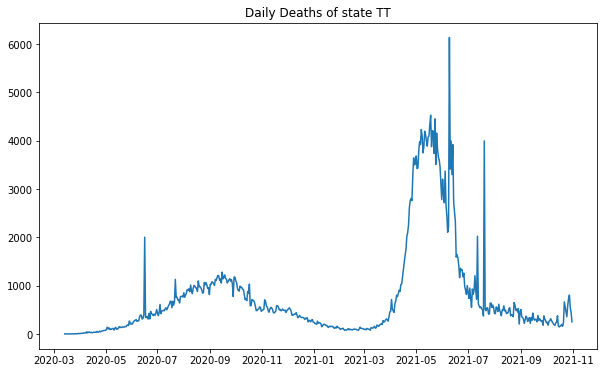

Total confirmed cases:  34284758
Total deaths reported:  458475
nCFR of State TT =  1.3372560482999472
cCFR of State TT =  1.0251612016655045
Percentage reported (CFR of 0.1%) of state  TT :  9.754563461584123 %


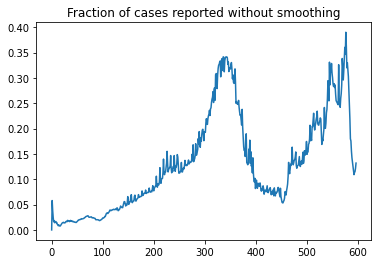

Fraction of cases reported with 95% confidence interval


<Figure size 720x360 with 0 Axes>

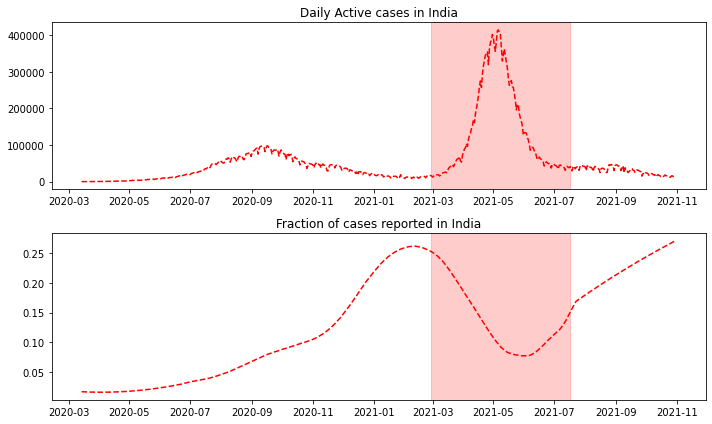

In [21]:
state = 'TT'
plot_plt1(state, 2)